In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [5]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [6]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [7]:
from pymono.cnn_func import ResNet10

In [8]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
data_dir = Path(os.environ['MONOLITH_DATA'])

In [11]:
crystal = os.path.join(data_dir, "BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX")

In [12]:
crystal

'/home/investigator/Data/monolithic_csi/BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX'

# BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_fano_NX_short

- BGO crystal with Fano factor

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 4.5 k photons per point (BGO, with ~9 k photons/MeV)
- 2MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation

### Short
- Consider only positions (not energy)

## Setup

In [13]:
imgs, mdata = select_image_and_lbl(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


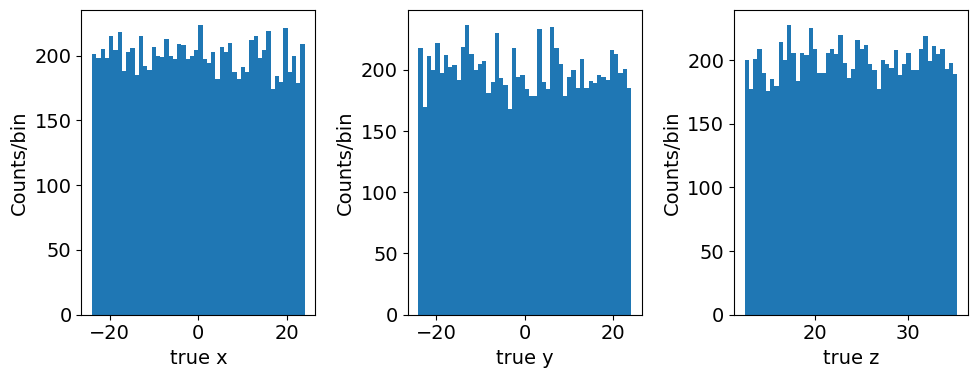

In [14]:
plot_true_positions(mdata)

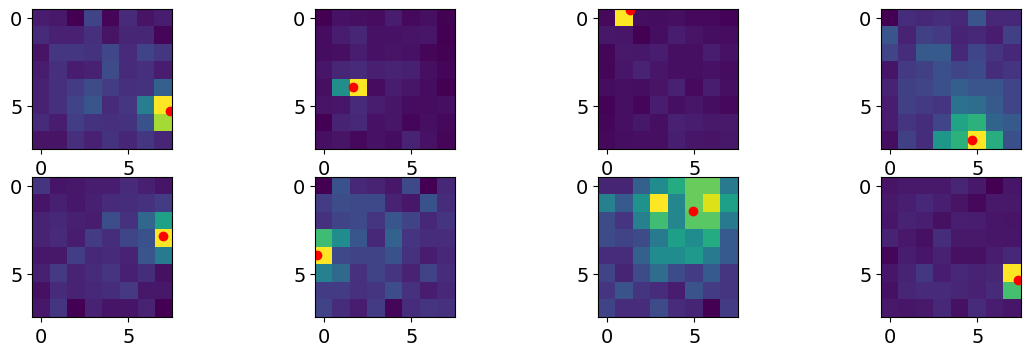

In [15]:
plot_images(imgs, mdata, range(0,8))

In [16]:
imgs[0]

array([[12., 11.,  6., 21.,  7., 15., 10., 12.],
       [15., 13., 13., 16., 10., 14., 14.,  7.],
       [10., 18., 18., 17., 22., 15., 21., 18.],
       [12., 16., 12., 13., 23., 15., 16., 12.],
       [13., 16., 19., 23., 19., 16., 17., 29.],
       [13., 16., 21., 26., 15., 18., 38., 81.],
       [15., 12., 20., 17., 16., 17., 25., 71.],
       [10., 10., 16., 13., 17., 14., 18., 14.]], dtype=float32)

In [17]:
np.mean(imgs[0])

17.796875

In [18]:
np.std(imgs[0])

11.715614

In [19]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


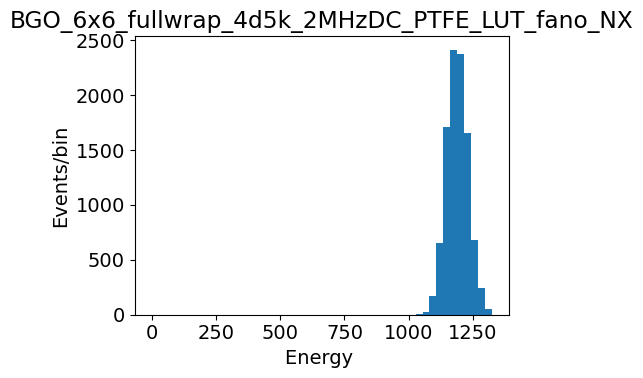

In [20]:
plot_energies2({"BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_fano_NX":energy}, xmin=0, xmax=max(energy),num_bins = 50)

In [21]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 1189.59 sigma = 3.48 % FWHM = 8.01 %


## Short run
- Use a fraction (1/3) of data set.
- No normalization

In [22]:
first_file = 0  # initial file indx
last_file  = 30  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [23]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = MonoDataset(crystal, first_file, last_file, xyze=True)  # No comparison with energy only xyz


Running Monoataset with norm = False, resize=False, xyze=True
Loading files with indexes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
meta[1:-1] =[-17.736462   5.652053  35.20759 ]


In [24]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


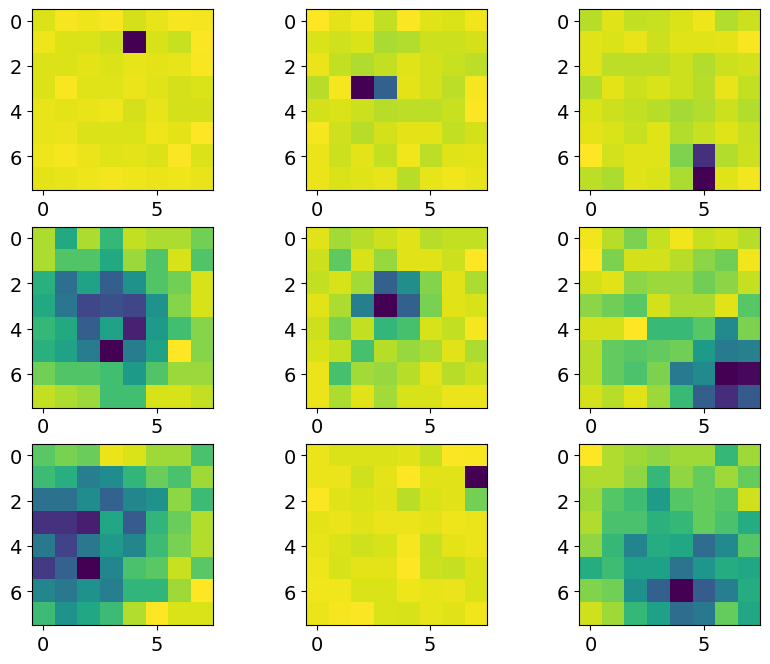

In [25]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [26]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[  9.,  14.,  22.,  16.,  17.,  15.,  15.,  13.],
        [ 13.,  12.,  24.,  18.,   9.,  14.,  11.,   6.],
        [ 12.,  20.,  14.,  19.,  17.,  18.,  18.,  16.],
        [ 21.,  19.,  16.,  16.,  18.,  15.,  15.,  15.],
        [ 15.,  13.,  19.,  21.,  18.,  25.,  15.,  17.],
        [ 14., 182.,  25.,  13.,  20.,  20.,  13.,  14.],
        [ 10.,  15.,  21.,  17.,  22.,  16.,  18.,  11.],
        [  7.,  15.,  15.,  13.,  14.,  10.,  19.,  17.]])


### Train the network with CNN_basic 

In [27]:
# Load the model. Be careful to set energy to false if using conventional CNN (just positions)
model = CNN_3x3(dropout=False, energy=False).to(device)  
print(model)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [28]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [29]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 337.5904541015625
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 265.2047119140625


In [30]:
epochs = 10

In [31]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
Train Step 200/210, Loss: 2.3298535346984863
--- EPOCH 0 AVG TRAIN LOSS: 10.91404475711641
--- EPOCH 0 AVG VAL LOSS: 2.448788539568583

EPOCH 1
Train Step 200/210, Loss: 2.06196665763855
--- EPOCH 1 AVG TRAIN LOSS: 2.2545530682518367
--- EPOCH 1 AVG VAL LOSS: 2.096649901072184

EPOCH 2
Train Step 200/210, Loss: 2.0215721130371094
--- EPOCH 2 AVG TRAIN LOSS: 2.1102555609884717
--- EPOCH 2 AVG VAL LOSS: 2.197060751914978

EPOCH 3
Train Step 200/210, Loss: 1.9280694723129272
--- EPOCH 3 AVG TRAIN LOSS: 1.95119126694543
--- EPOCH 3 AVG VAL LOSS: 1.797713694969813

EPOCH 4
Train Step 200/210, Loss: 1.9313650131225586
--- EPOCH 4 AVG TRAIN LOSS: 1.9103696244103567
--- EPOCH 4 AVG VAL LOSS: 1.9791559318701426

EPOCH 5
Train Step 200/210, Loss: 1.7027918100357056
--- EPOCH 5 AVG TRAIN LOSS: 1.8295560774349031
--- EPOCH 5 AVG VAL LOS

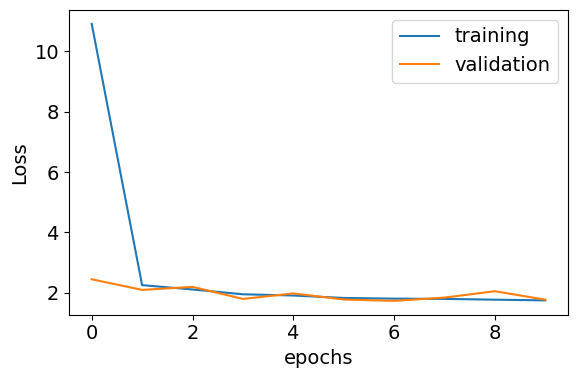

In [32]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [33]:
tdeltas = evaluate_cnn(test_loader, model, device, energy=False)

In [34]:
#plot_true_predicted(tdeltas, nbins = 50)

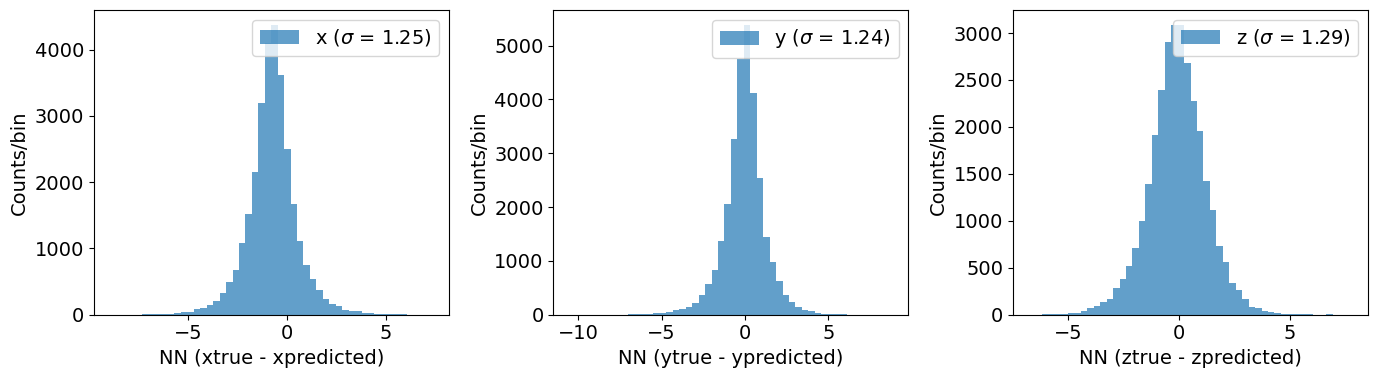

In [35]:
plotxyz(tdeltas, nbins=50)

In [42]:
#plotxyze(tdeltas, nbins=50)

## Normalization

In [36]:
means, stds = get_means_stds(dir=crystal)

files in dir: 100
shape -> (10000, 8, 8)
mean img0 =19.40625
std  img0 =25.696372985839844


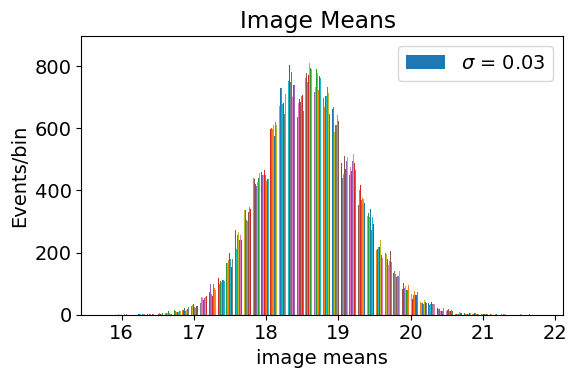

In [37]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

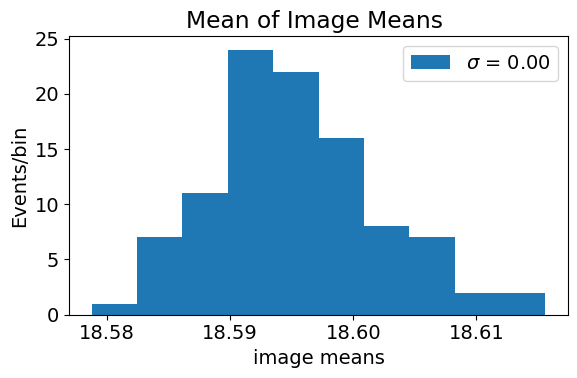

In [39]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [46]:
imean = np.mean(meansx)

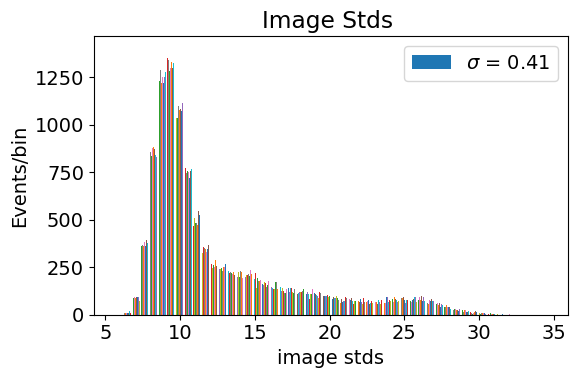

In [41]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

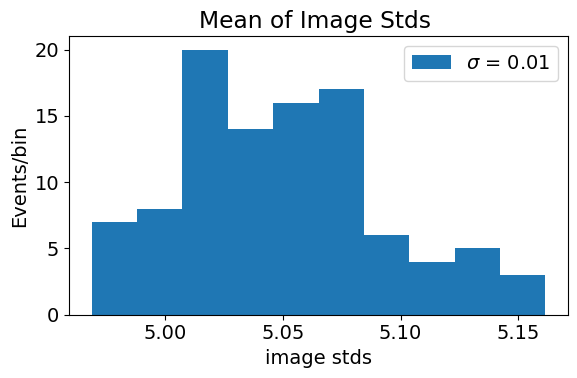

In [42]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [44]:
isigma = np.mean(stdsx)

In [47]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 18.595125198364258, std = 5.049670696258545


### Run with full stats and normalization 

In [48]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [49]:
dataset = MonoDataset(crystal, first_file, last_file, norm=True, resize=False, mean=imean, std=isigma,xyze=True)  # No comparison with energy only xyz



Running Monoataset with norm = True, resize=False, xyze=True
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
meta[1:-1] =[-17.736462   5.652053  35.20759 ]


In [50]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


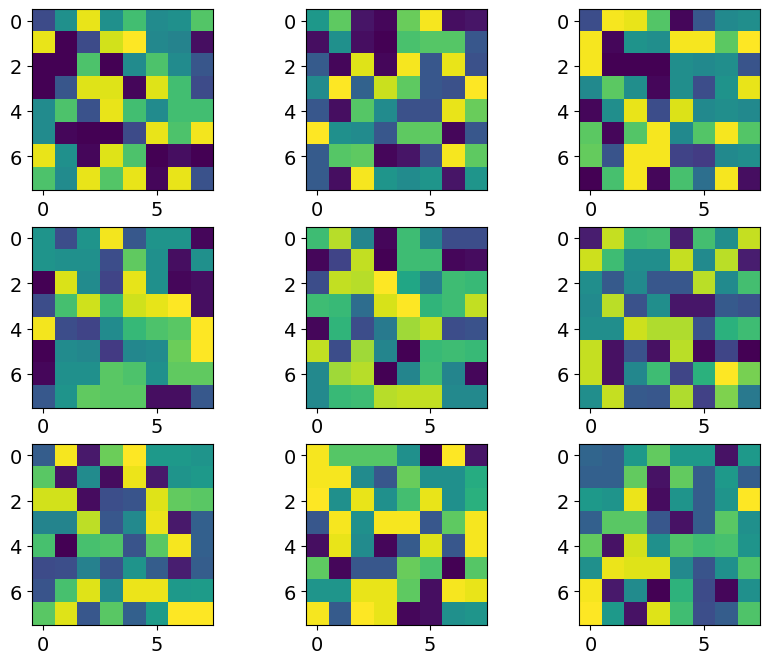

In [51]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [52]:
model = CNN_3x3(dropout=False, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [53]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=20, iprnt=200)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
Train Step 200/700, Loss: 2.251840829849243
Train Step 400/700, Loss: 2.112534761428833
Train Step 600/700, Loss: 2.044196844100952
Validation Step 200/200, Loss: 2.248180389404297
--- EPOCH 0 AVG TRAIN LOSS: 5.406419539111001
--- EPOCH 0 AVG VAL LOSS: 2.178903267979622

EPOCH 1
Train Step 200/700, Loss: 2.0173909664154053
Train Step 400/700, Loss: 1.8502362966537476
Train Step 600/700, Loss: 1.926581859588623
Validation Step 200/200, Loss: 1.7624895572662354
--- EPOCH 1 AVG TRAIN LOSS: 1.88790

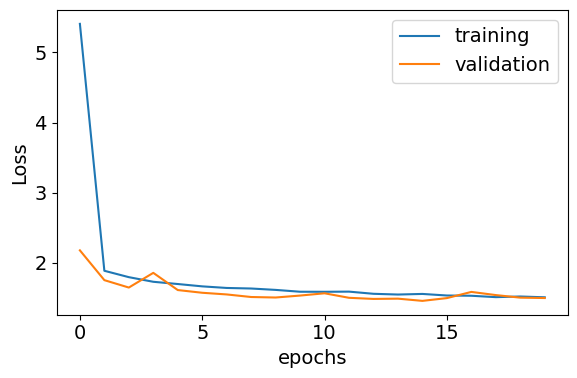

In [54]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))


In [56]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6, energy=False)


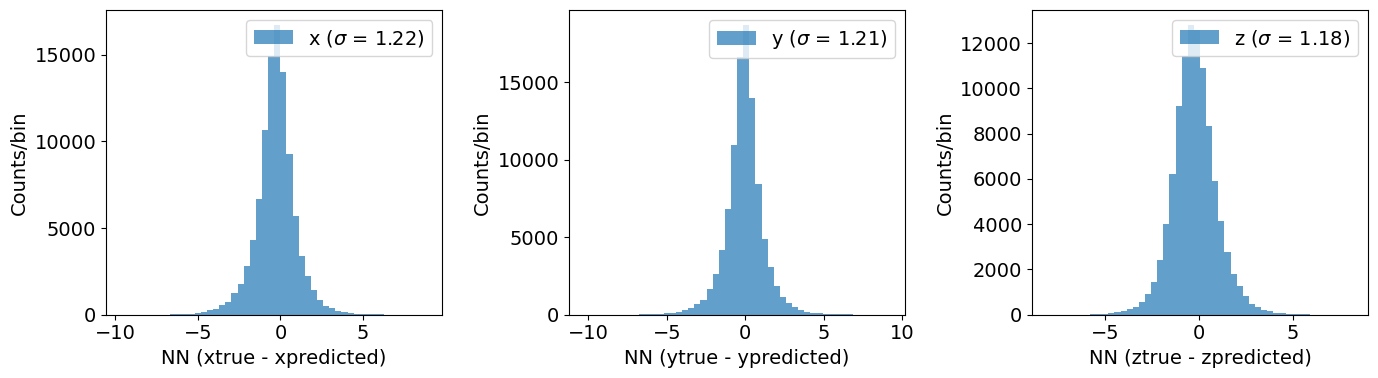

In [57]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [58]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [59]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [60]:
#define the model
model = ResNet10(ResBlock, debug=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [61]:
print(model)

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-0

In [62]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [63]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
 ResNet10: input data shape =>torch.Size([1000, 1, 8, 8])
 ResNet10: after conv1 =>torch.Size([1000, 64, 8, 8])
 ResNet10: after layer0 =>torch.Size([1000, 64, 8, 8])
 ResNet10: after layer1 =>torch.Size([1000, 128, 4, 4])
 ResNet10: after layer2 =>torch.Size([1000, 256, 2, 2])
 ResNet10: after layer3 =>torch.Size([1000, 512, 1, 1])
 ResNet10: after avgpool =>torch.Size([1000, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([1000, 512])
 ResNet10: after fc =>torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/700, Loss: 323.3596496582031
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/700, Loss: 270.758544921875


In [68]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
  

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


In [69]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=500, epochs=20, iprnt=200)

Training with  ->350000 images
size of train loader  ->700 images
Evaluating with  ->100000 images
size of eval loader  ->200 images
Running for epochs ->20

EPOCH 0
Train Step 200/700, Loss: 1.38531494140625
Train Step 400/700, Loss: 1.4791386127471924
Train Step 600/700, Loss: 1.4380336999893188
Validation Step 200/200, Loss: 1.5889678001403809
--- EPOCH 0 AVG TRAIN LOSS: 1.4997339265687124
--- EPOCH 0 AVG VAL LOSS: 1.6457025277614594

EPOCH 1
Train Step 200/700, Loss: 1.4871975183486938
Train Step 400/700, Loss: 1.5855869054794312
Train Step 600/700, Loss: 1.370745062828064
Validation Step 200/200, Loss: 1.3792425394058228
--- EPOCH 1 AVG TRAIN LOSS: 1.4717766860553196
--- EPOCH 1 AVG VAL LOSS: 1.4658126825094222

EPOCH 2
Train Step 200/700, Loss: 1.5115787982940674
Train Step 400/700, Loss: 1.47444486618042
Train Step 600/700, Loss: 1.455223560333252
Validation Step 200/200, Loss: 1.363623023033142
--- EPOCH 2 AVG TRAIN LOSS: 1.4525602827753339
--- EPOCH 2 AVG VAL LOSS: 1.438688689

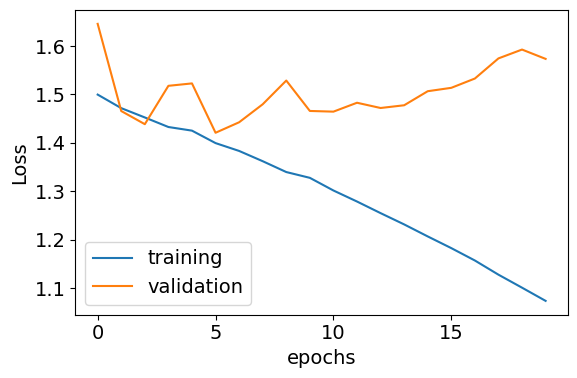

In [71]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))



In [66]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6, energy=False)

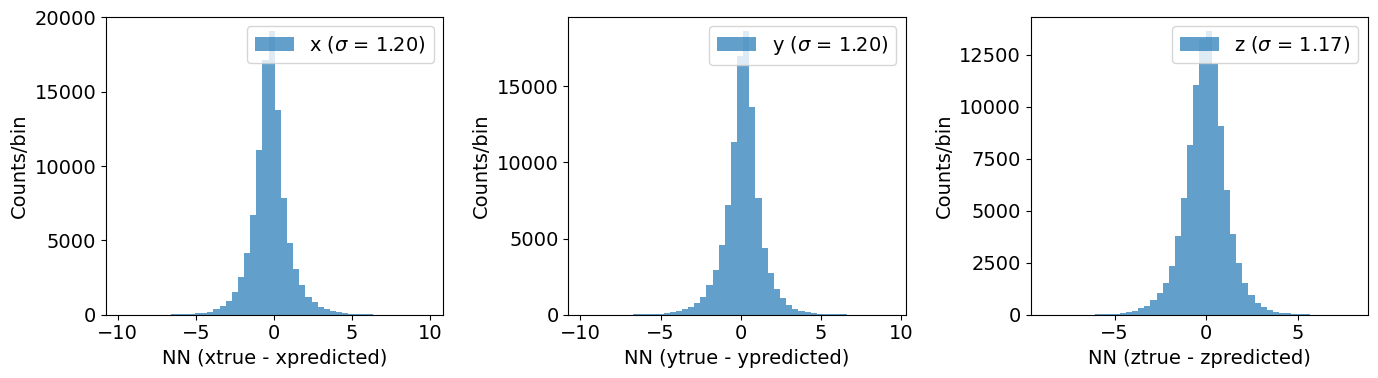

In [72]:
plotxyz(tdeltas, nbins=50)